## Fertilizer Recommendation

Dataset download from [Keggle](https://www.kaggle.com/datasets/nishchalchandel/fertilizer-recommendation/data)

In [154]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [155]:
df = pd.read_csv(r'../data/fertilizer_dataset.csv')

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3100 non-null   float64
 1   Moisture     3100 non-null   float64
 2   Rainfall     3100 non-null   float64
 3   PH           3100 non-null   float64
 4   Nitrogen     3100 non-null   float64
 5   Phosphorous  3100 non-null   float64
 6   Potassium    3100 non-null   float64
 7   Carbon       3100 non-null   float64
 8   Soil         3100 non-null   object 
 9   Crop         3100 non-null   object 
 10  Fertilizer   3100 non-null   object 
 11  Remark       3100 non-null   object 
dtypes: float64(8), object(4)
memory usage: 290.8+ KB


In [157]:
df.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."


Looking for values in categorical columns

In [158]:
df.nunique()

Temperature    2947
Moisture       2960
Rainfall       2950
PH             2961
Nitrogen       2947
Phosphorous    2948
Potassium      2945
Carbon         2940
Soil              5
Crop             31
Fertilizer       10
Remark           10
dtype: int64

In [159]:
df['Soil'].value_counts()

Soil
Acidic Soil      1519
Peaty Soil        537
Neutral Soil      510
Loamy Soil        489
Alkaline Soil      45
Name: count, dtype: int64

In [160]:
df['Crop'].value_counts()

Crop
rice            100
wheat           100
Mung Bean       100
Tea             100
millet          100
maize           100
Lentil          100
Jute            100
Coffee          100
Cotton          100
Ground Nut      100
Peas            100
Rubber          100
Sugarcane       100
Tobacco         100
Kidney Beans    100
Moth Beans      100
Coconut         100
Black gram      100
Adzuki Beans    100
Pigeon Peas     100
Chickpea        100
banana          100
grapes          100
apple           100
mango           100
muskmelon       100
orange          100
papaya          100
pomegranate     100
watermelon      100
Name: count, dtype: int64

In [161]:
len(df["Crop"].unique())

31

In [162]:
df['Fertilizer'].value_counts()

Fertilizer
DAP                           1054
Water Retaining Fertilizer     675
Compost                        375
Muriate of Potash              326
Lime                           181
Balanced NPK Fertilizer        157
Urea                           154
Organic Fertilizer              95
Gypsum                          52
General Purpose Fertilizer      31
Name: count, dtype: int64

In [163]:
df.isnull().sum()

Temperature    0
Moisture       0
Rainfall       0
PH             0
Nitrogen       0
Phosphorous    0
Potassium      0
Carbon         0
Soil           0
Crop           0
Fertilizer     0
Remark         0
dtype: int64

### Exploratory Data Analysis


Numerical columns for outlier analysis: ['Temperature', 'Moisture', 'Rainfall', 'PH', 'Nitrogen', 'Phosphorous', 'Potassium', 'Carbon']


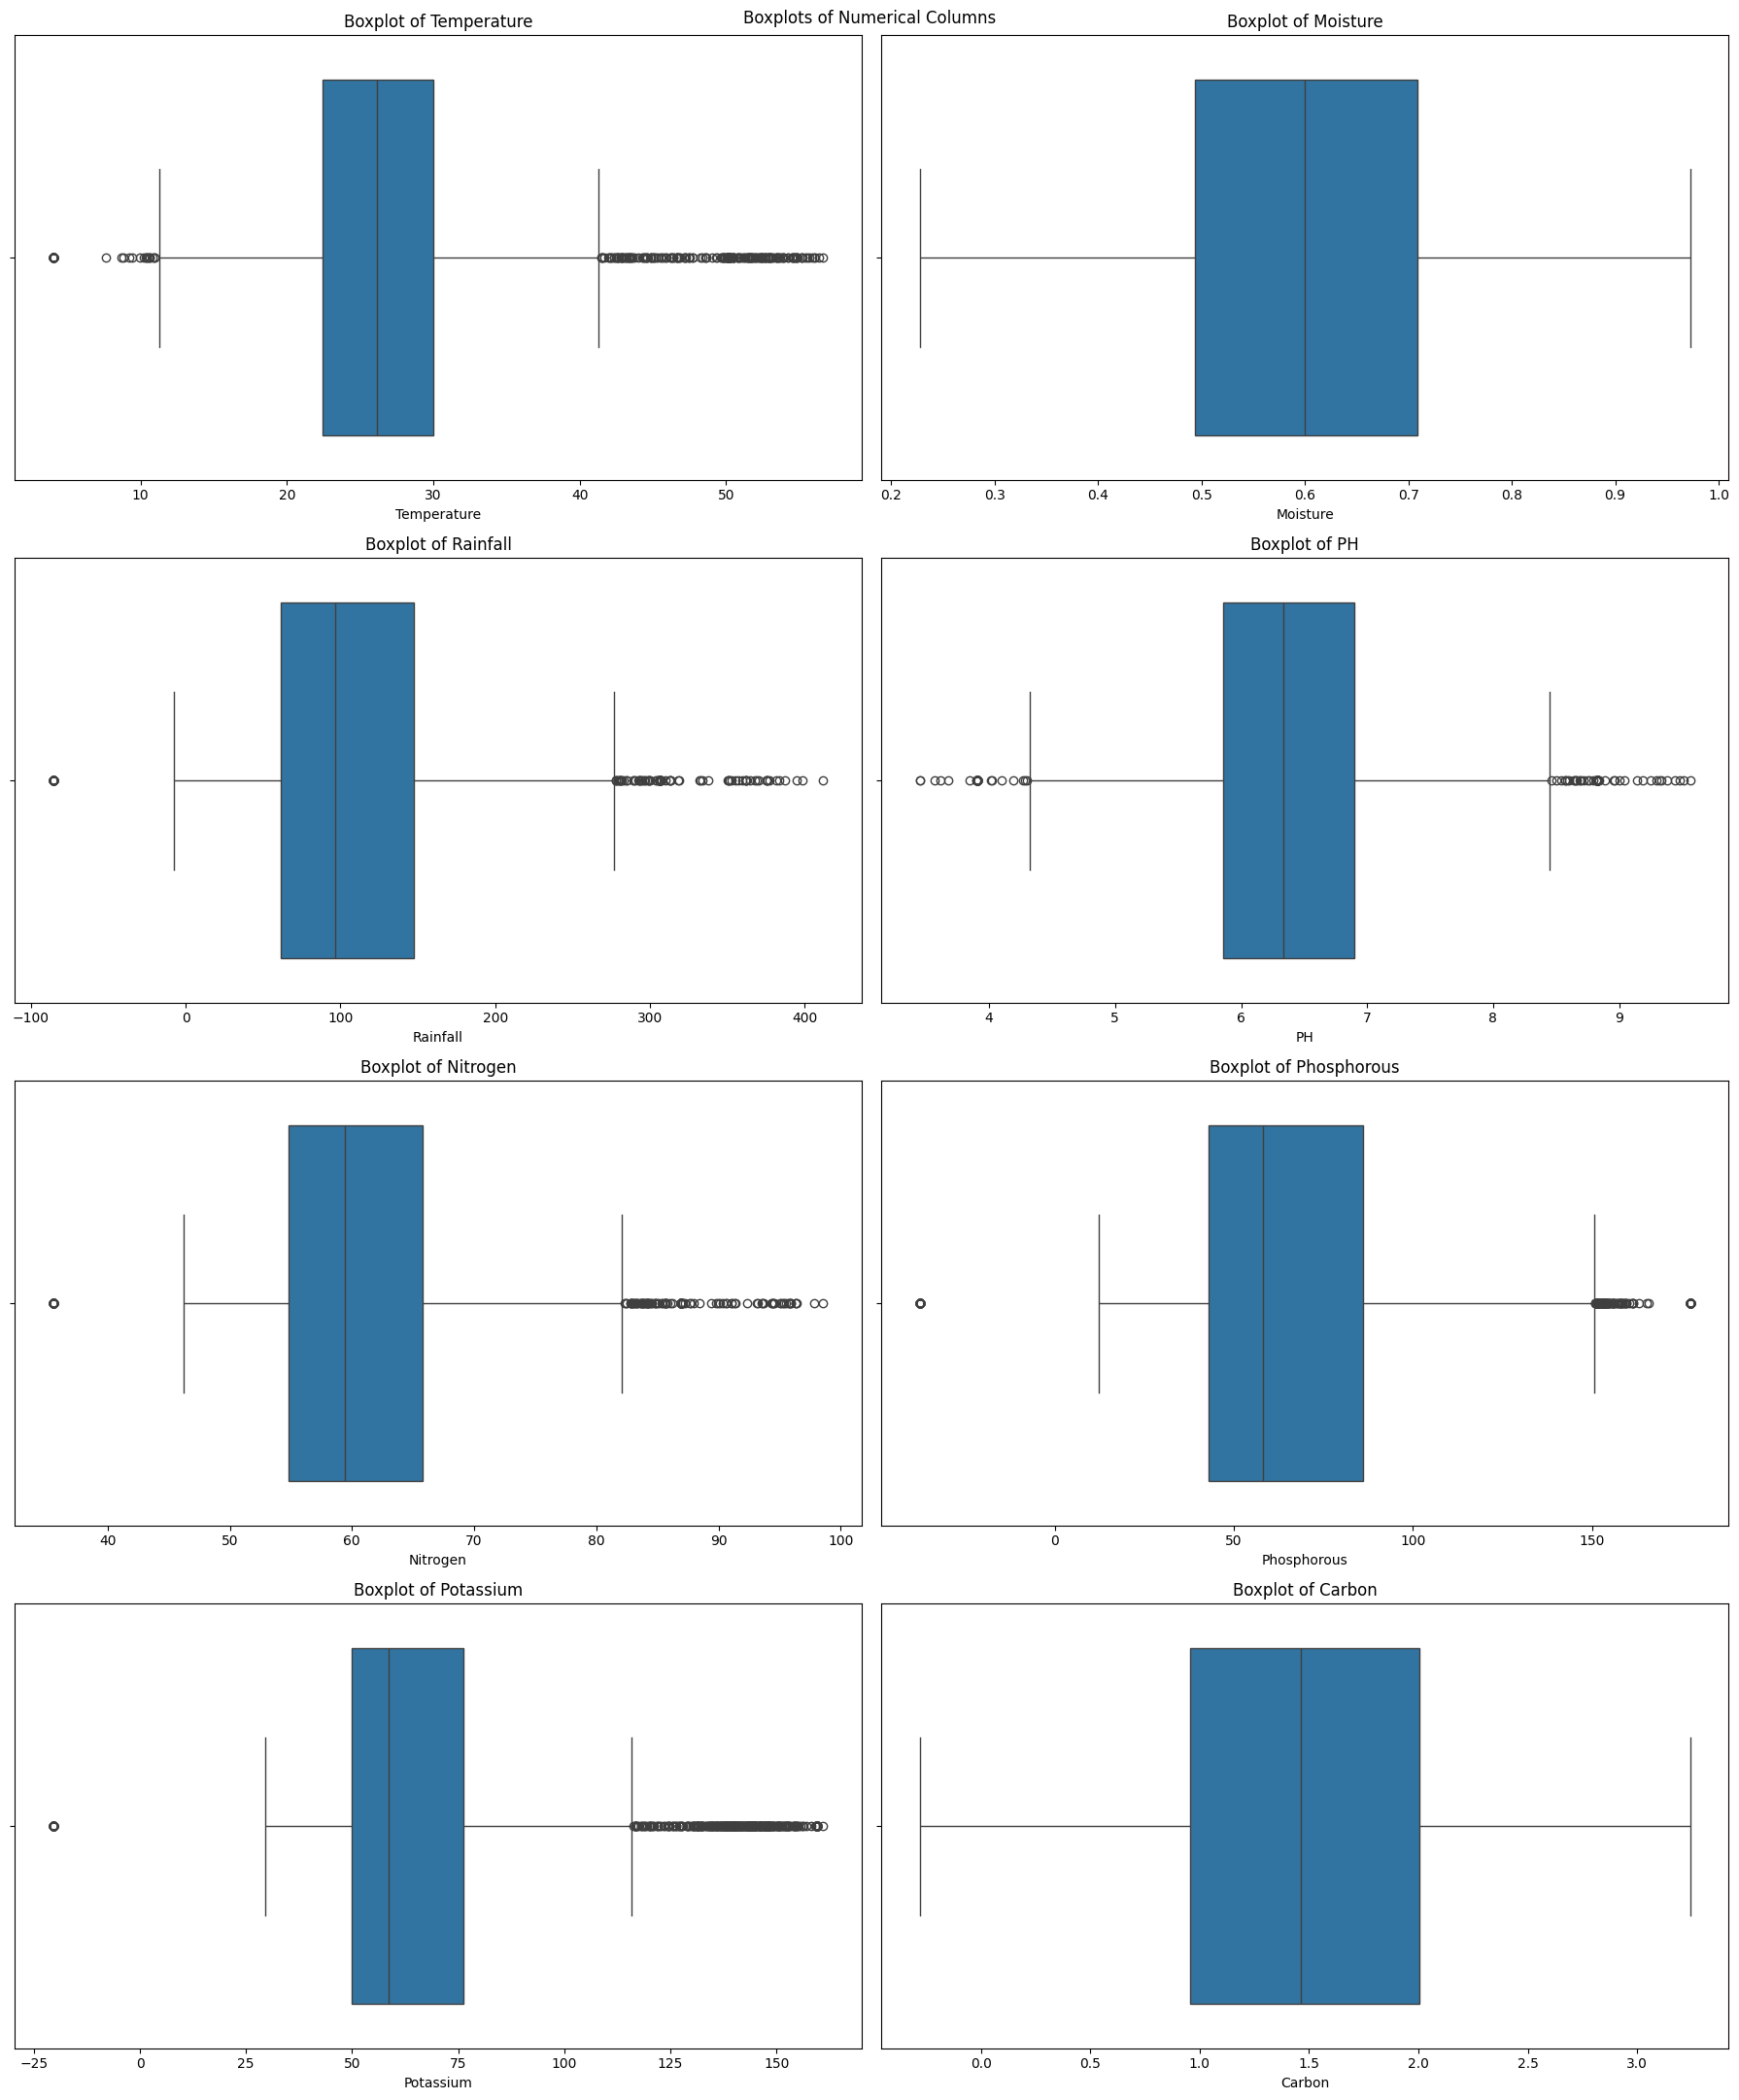

In [164]:
# Box plots for each numerical column
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"\nNumerical columns for outlier analysis: {numerical_cols}")
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns')
plt.tight_layout()
plt.show()

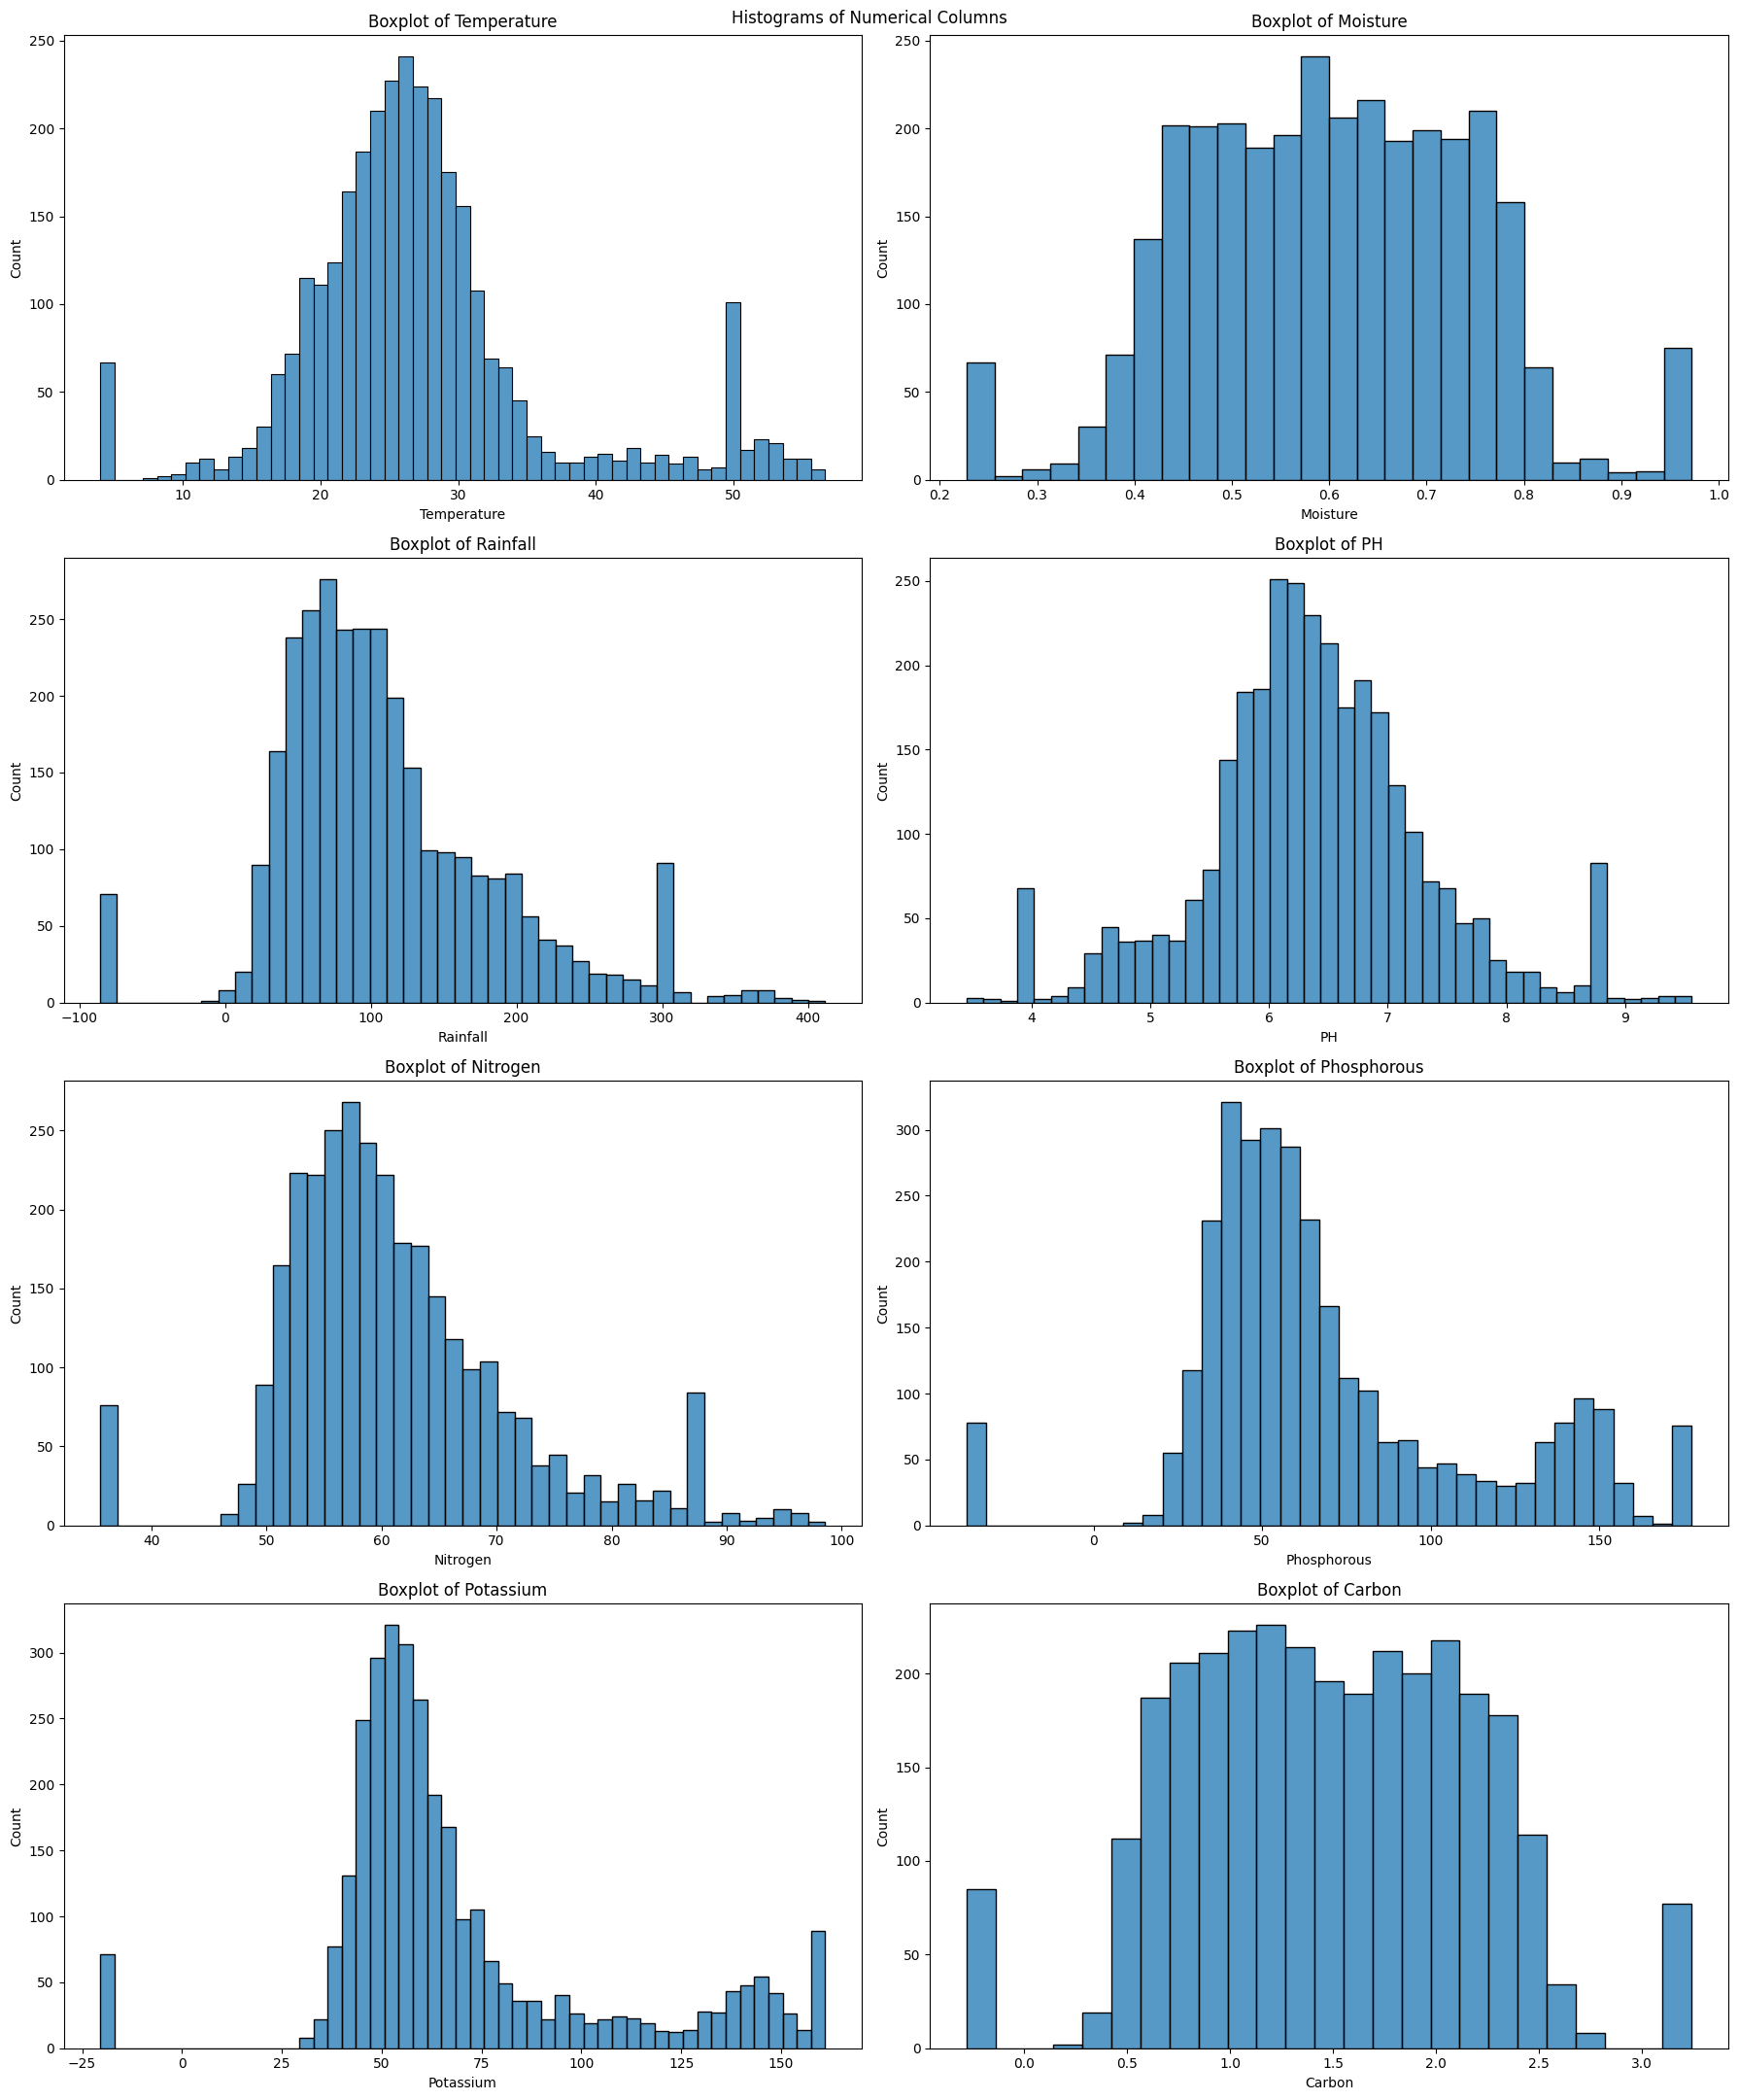

In [165]:
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Histograms of Numerical Columns')
plt.tight_layout()
plt.show()

We can clearly see that there are outliers in dataset, so we need to remove them.

In [166]:
# Remove Outliers Using the IQR Method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for rows without outliers
mask = ~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)

# Filter out rows with outliers
df_cleaned = df[mask]
print(f"Original dataset size: {df.shape}")
print(f"Dataset size after removing outliers: {df_cleaned.shape}")

Original dataset size: (3100, 12)
Dataset size after removing outliers: (1761, 12)


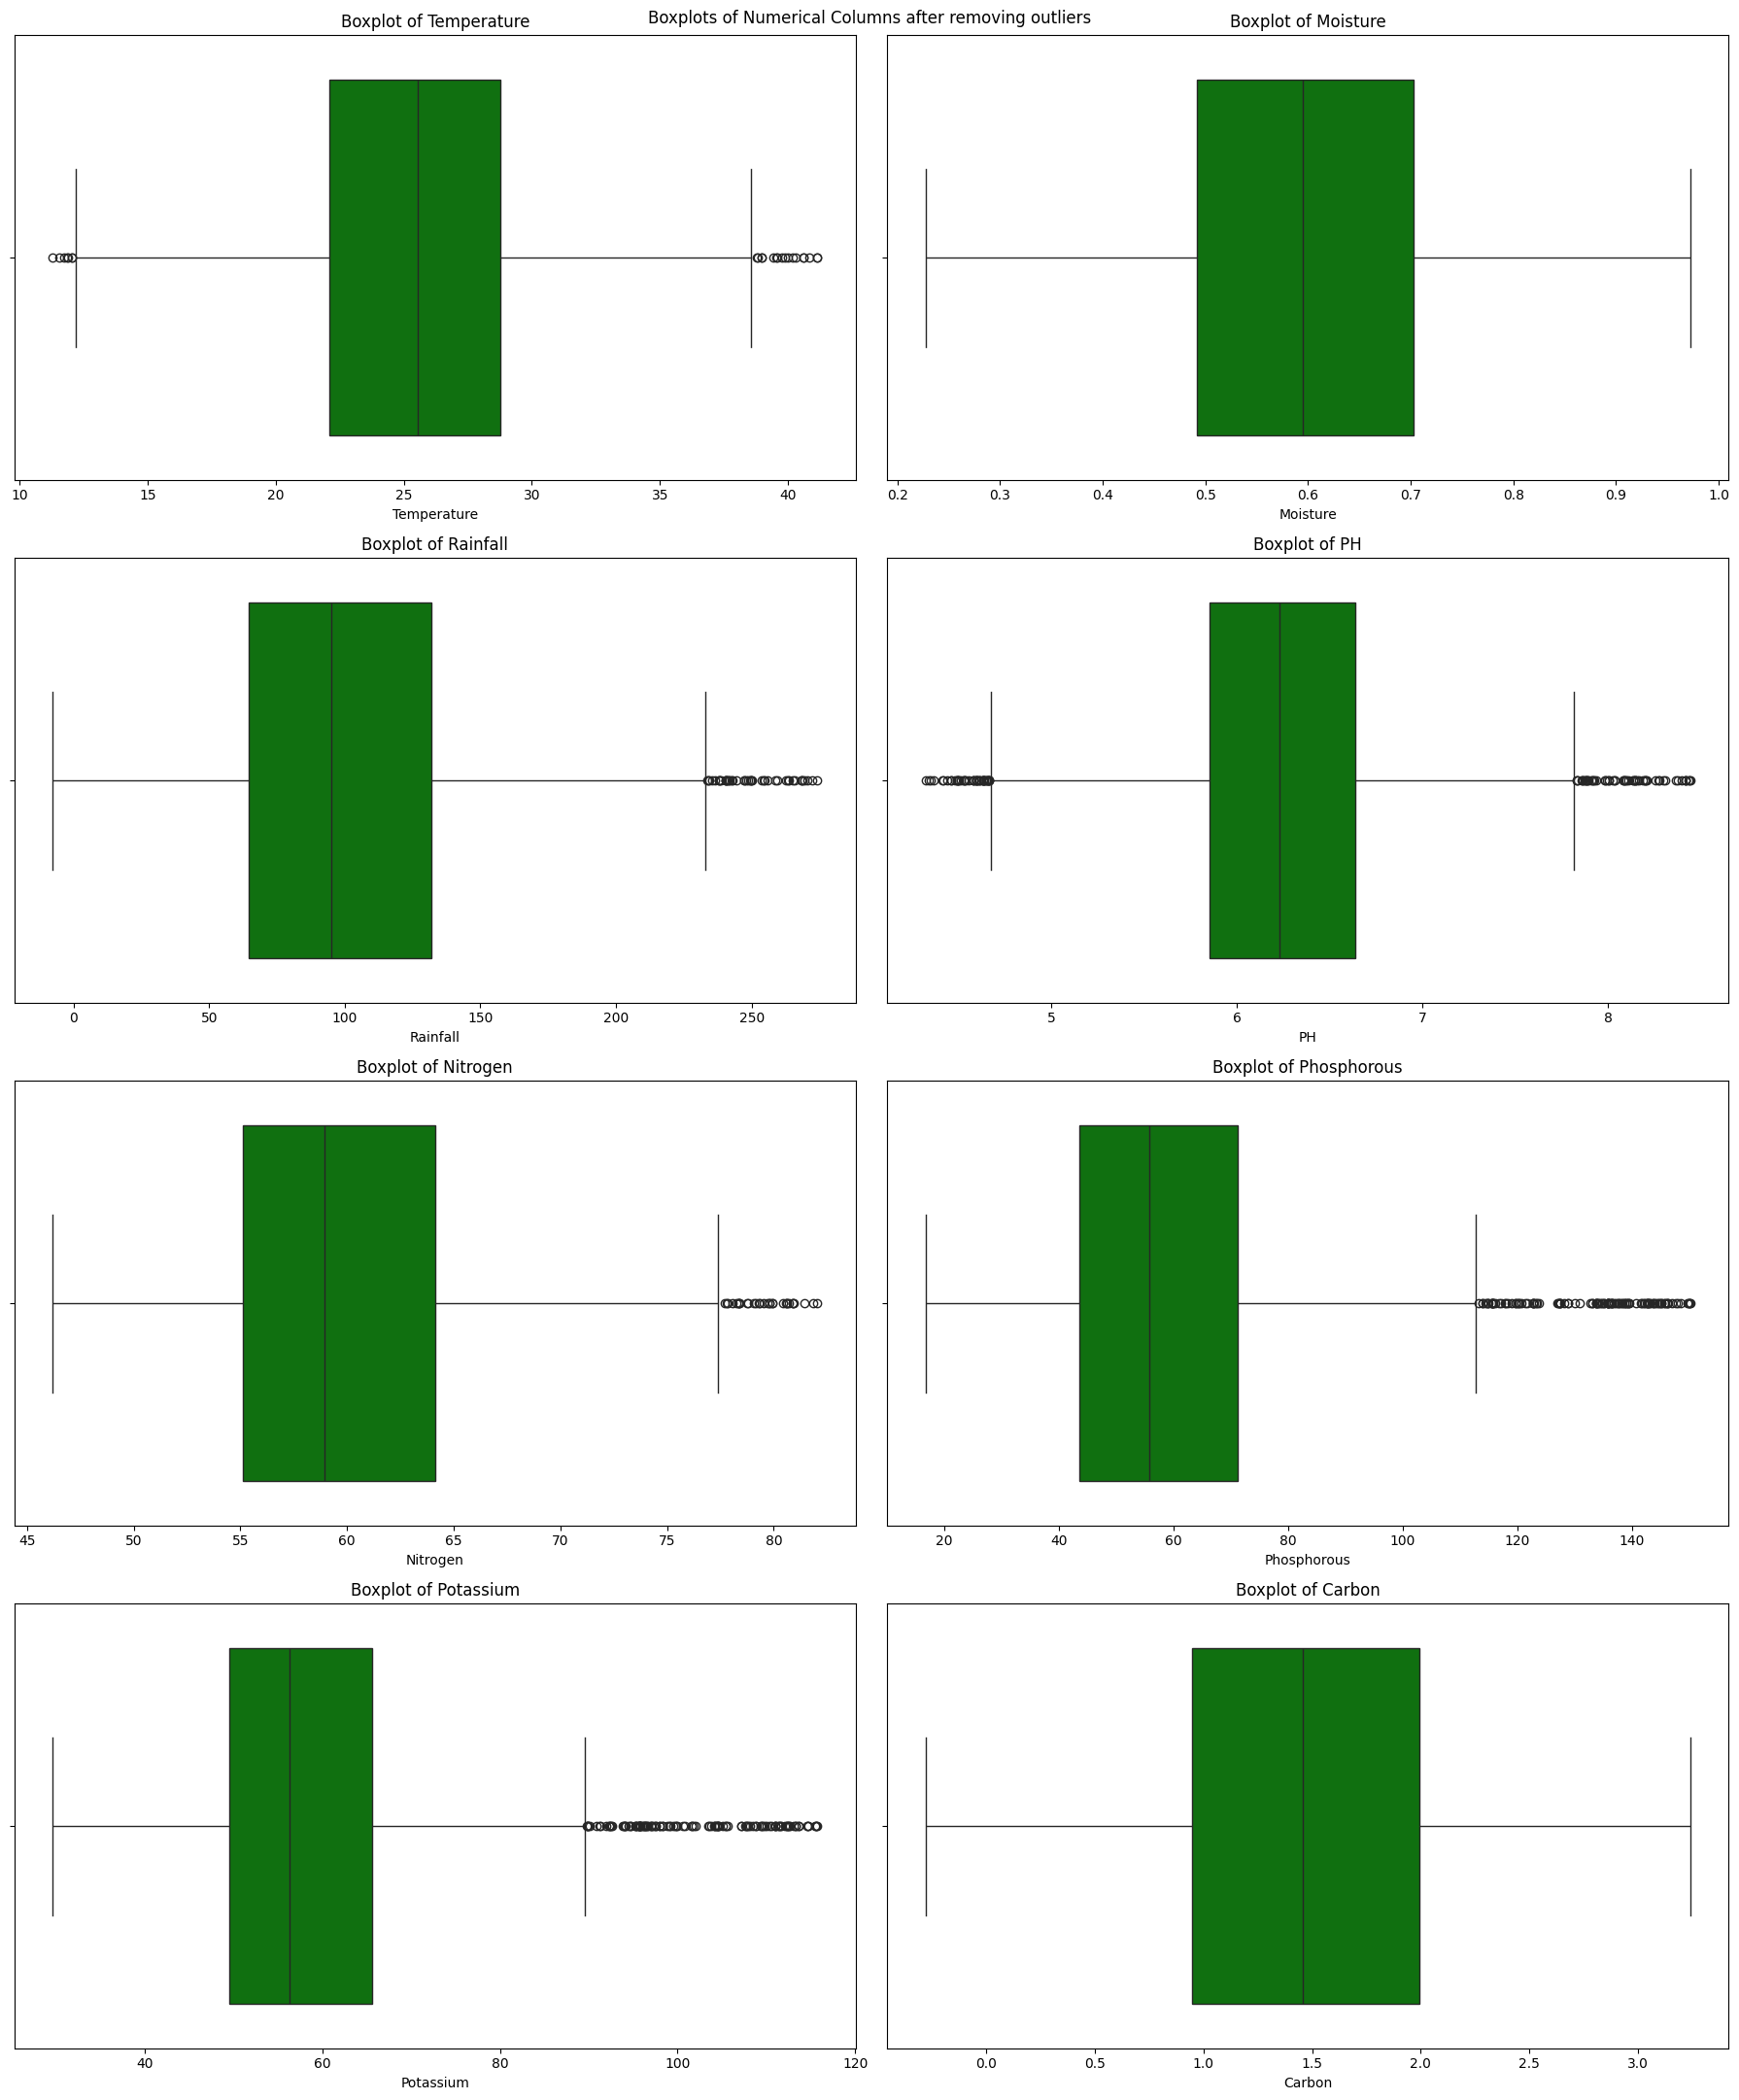

In [167]:
# Box plots for each numerical column after removing outliers
numerical_cols_cleaned = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols_cleaned):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df_cleaned[col], color='green')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns after removing outliers')
plt.tight_layout()
plt.show()

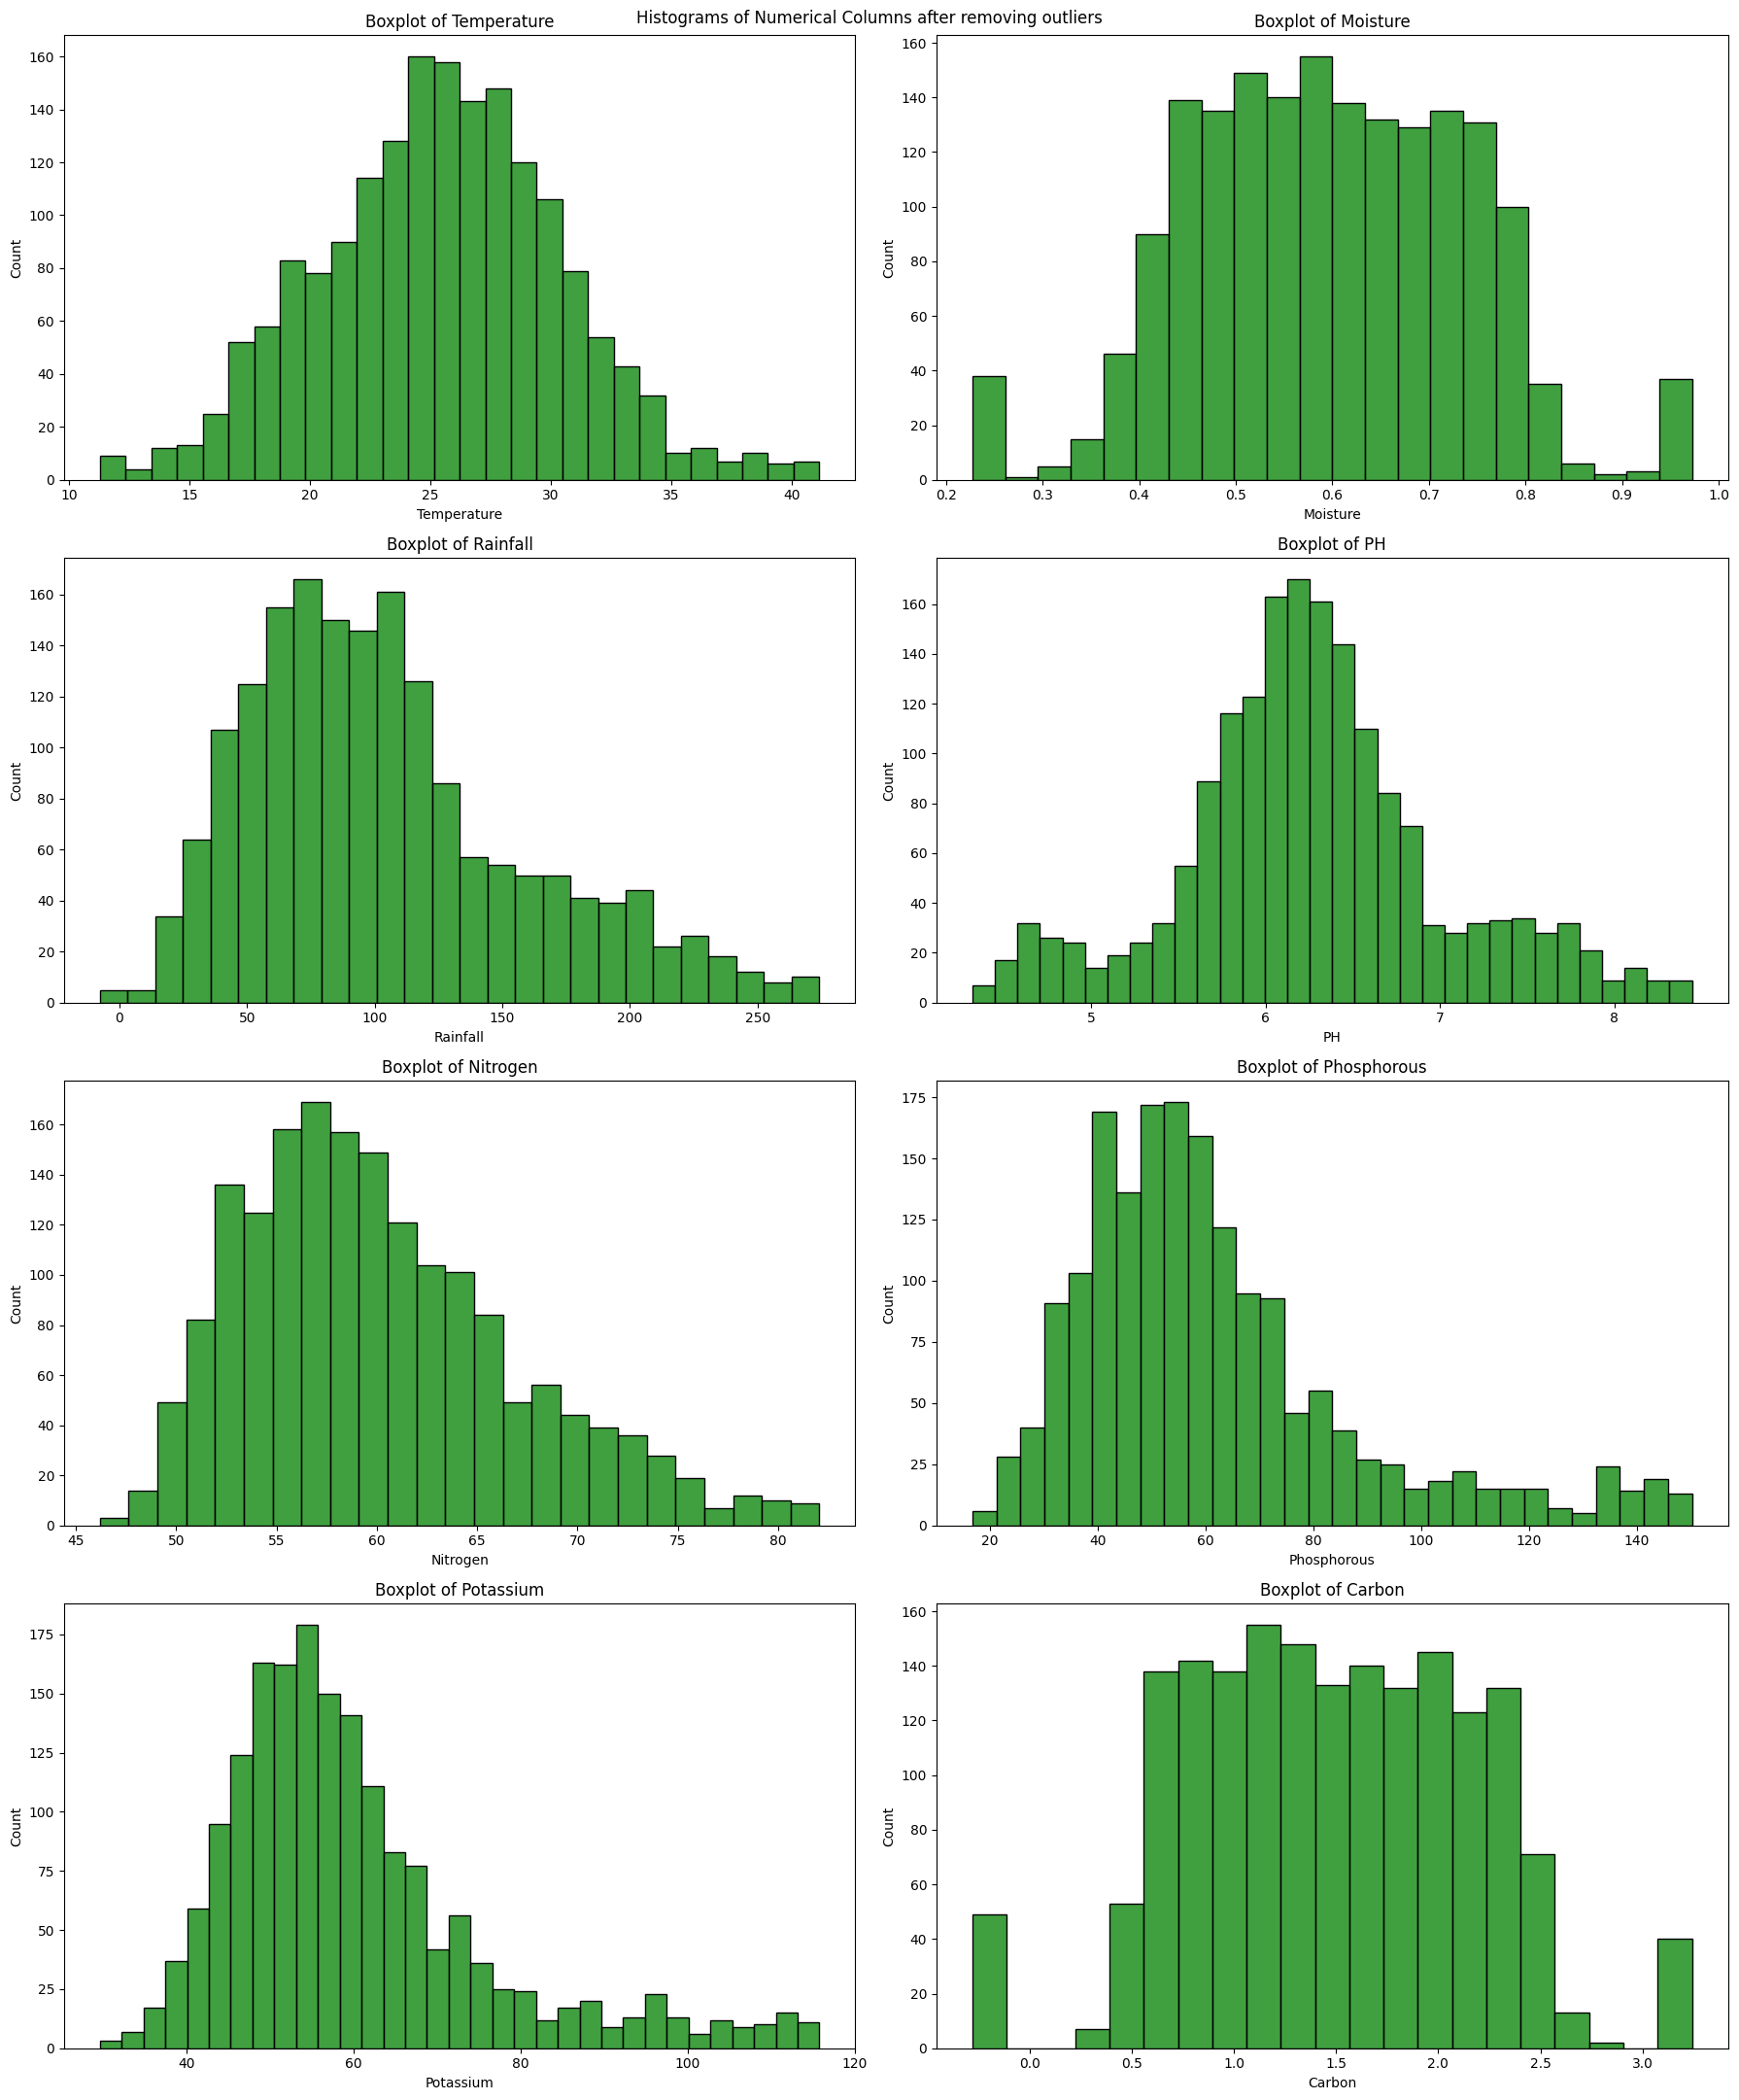

In [168]:
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(x=df_cleaned[col], color='green')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Histograms of Numerical Columns after removing outliers')
plt.tight_layout()
plt.show()

In [169]:
df = df_cleaned

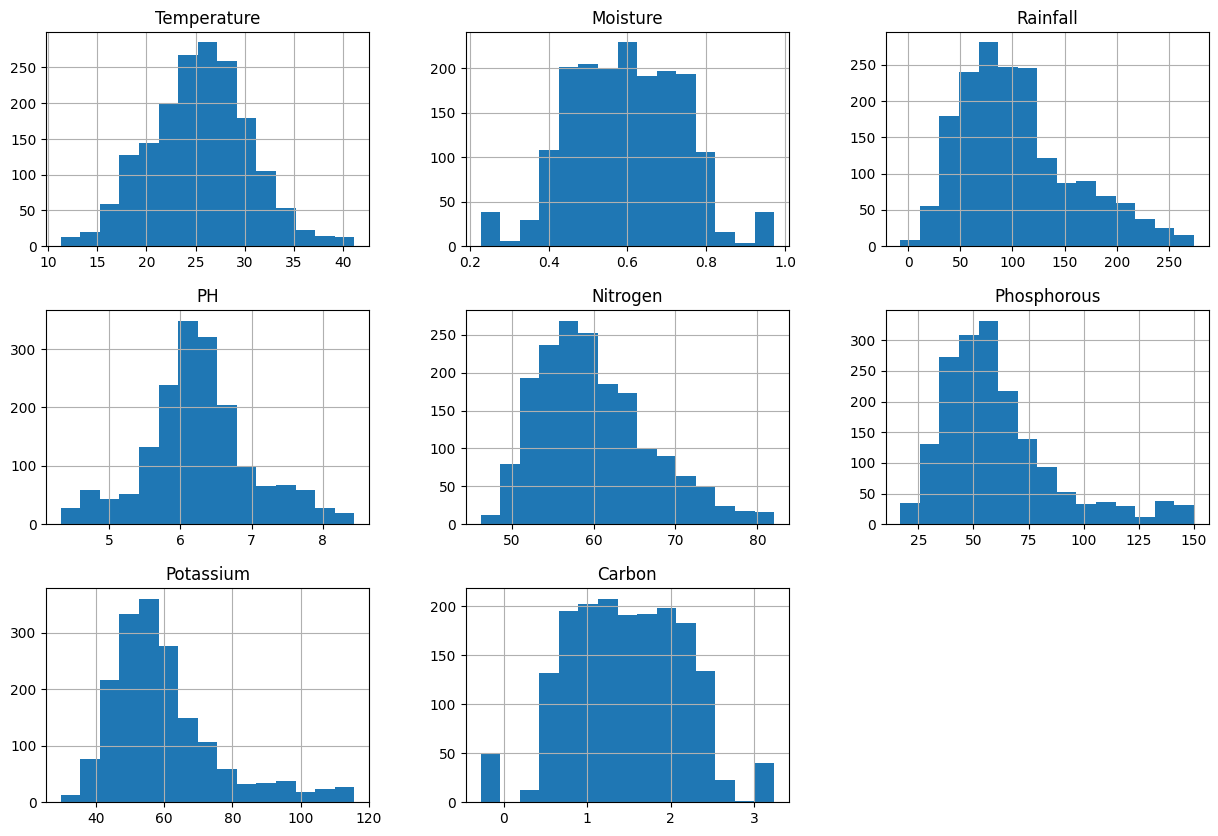

In [170]:
# Histograms for the numerical cols
df[['Temperature','Moisture','Rainfall','PH','Nitrogen', 'Phosphorous', 'Potassium','Carbon']].hist(bins=15, figsize=(15, 10))
plt.show()

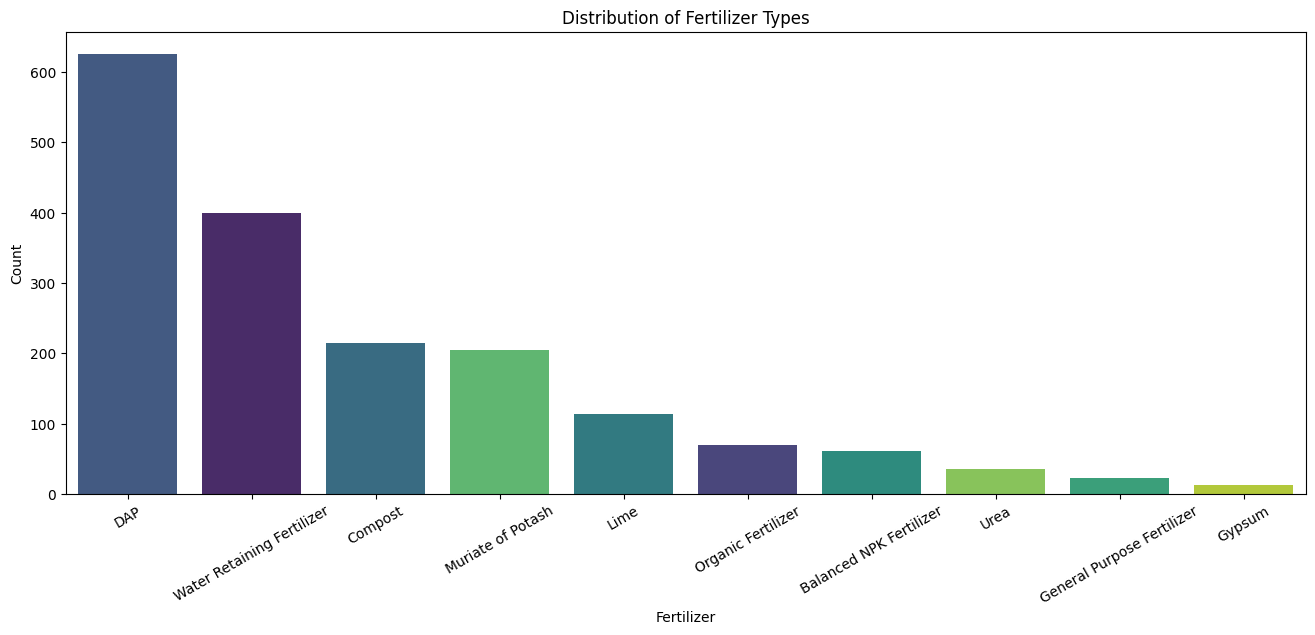

In [171]:
# Visualize fertilizer distribution
plt.figure(figsize=(16,6))
sns.countplot(x=df['Fertilizer'], order=df['Fertilizer'].value_counts().index, palette='viridis', hue=df['Fertilizer'])
plt.xticks(rotation=30)
plt.title('Distribution of Fertilizer Types')
plt.xlabel('Fertilizer')
plt.ylabel('Count')
plt.show()

Here we see that there is a class imbalance in target variable

<Axes: >

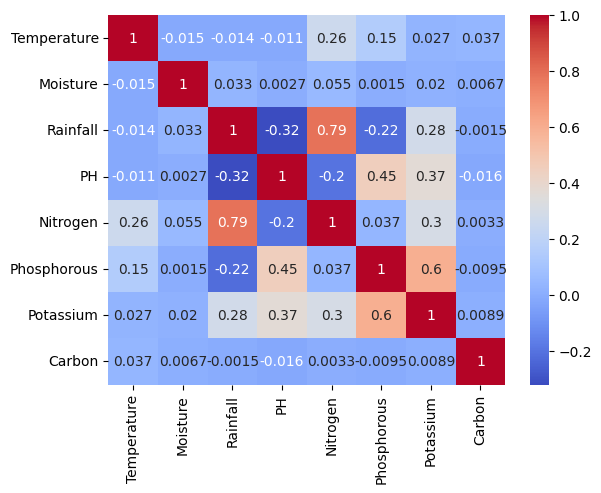

In [172]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])
corr = numerical_data.corr()
sns.heatmap(corr,annot=True,cbar=True , cmap='coolwarm')

## Data Preprocessing

In [173]:
crop_df = pd.read_csv("../data/crop.csv")

crop_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [174]:
# Normalize crop names (lowercase + remove spaces) and get unique values
fert_crops = set(df["Crop"].str.lower().str.replace(" ", "").unique())
crop_labels = set(crop_df["label"].str.lower().str.replace(" ", "").unique())

# Find intersection (matching crops)
matching_crops = fert_crops.intersection(crop_labels)

# Convert back to a sorted list
matching_crops = sorted(list(matching_crops))

print("Matching crops (normalized):")
print(matching_crops)
print(f"\nTotal matching crops: {len(matching_crops)}")

Matching crops (normalized):
['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']

Total matching crops: 22


In [175]:
# Convert crop names to lowercase for case-insensitive matching
df = df[df['Crop'].str.lower().str.replace(" ", "").isin(matching_crops)]

# Verify the result
print(f"Filtered DataFrame shape: {df.shape}")
print("\nRemaining crops:")
print(df['Crop'].value_counts())

Filtered DataFrame shape: (1300, 12)

Remaining crops:
Crop
Kidney Beans    74
banana          73
apple           73
grapes          71
Black gram      69
mango           68
muskmelon       68
Cotton          68
Coconut         66
maize           65
Lentil          63
watermelon      63
Pigeon Peas     62
Chickpea        59
Mung Bean       52
orange          51
pomegranate     50
Moth Beans      50
rice            45
Jute            45
Coffee          39
papaya          26
Name: count, dtype: int64


In [176]:
len(df["Crop"].unique())

22

In [177]:
# Prepare features and target variables
x = df.drop(['Fertilizer', 'Remark'], axis=1)
y = df['Fertilizer']

In [178]:
# onehot encode for categorical varibales
x = pd.get_dummies(x, columns=['Soil', 'Crop'], drop_first=False, dtype=np.int64)

In [179]:
x.head()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil_Acidic Soil,Soil_Alkaline Soil,...,Crop_banana,Crop_grapes,Crop_maize,Crop_mango,Crop_muskmelon,Crop_orange,Crop_papaya,Crop_pomegranate,Crop_rice,Crop_watermelon
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,0,0,...,0,0,0,0,0,0,0,0,1,0
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,0,0,...,0,0,0,0,0,0,0,0,1,0
7,21.342227,0.785753,249.980185,5.692240,72.089121,42.591255,68.035609,2.410625,0,0,...,0,0,0,0,0,0,0,0,1,0
9,21.296925,0.783450,211.049382,6.386646,72.711484,68.352057,94.695401,2.464714,0,0,...,0,0,0,0,0,0,0,0,1,0
18,21.865816,0.869469,187.923879,6.109553,69.987401,52.729565,62.923918,1.182529,0,0,...,0,0,0,0,0,0,0,0,1,0


In [180]:
y.unique()

array(['Water Retaining Fertilizer', 'Organic Fertilizer', 'DAP',
       'Compost', 'Lime', 'Balanced NPK Fertilizer',
       'General Purpose Fertilizer', 'Muriate of Potash', 'Urea',
       'Gypsum'], dtype=object)

To reduce class imbalace we use SMOTEENN method, which decrease the high frequency data and increase low freqeuncy data and come to an average level

In [181]:
smote_enn = SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=3))
x_resampled, y_resampled = smote_enn.fit_resample(x, y)

In [182]:
print("Original class distribution:")
print(Counter(y))

Original class distribution:
Counter({'DAP': 380, 'Water Retaining Fertilizer': 316, 'Compost': 176, 'Muriate of Potash': 176, 'Lime': 94, 'Balanced NPK Fertilizer': 58, 'Organic Fertilizer': 57, 'General Purpose Fertilizer': 22, 'Urea': 16, 'Gypsum': 5})


In [183]:
print("Class distribution after SMOTEENN:")
print(Counter(y_resampled))

Class distribution after SMOTEENN:
Counter({'Gypsum': 379, 'Urea': 373, 'Balanced NPK Fertilizer': 333, 'General Purpose Fertilizer': 332, 'Organic Fertilizer': 323, 'Muriate of Potash': 317, 'Lime': 316, 'DAP': 259, 'Compost': 141, 'Water Retaining Fertilizer': 54})


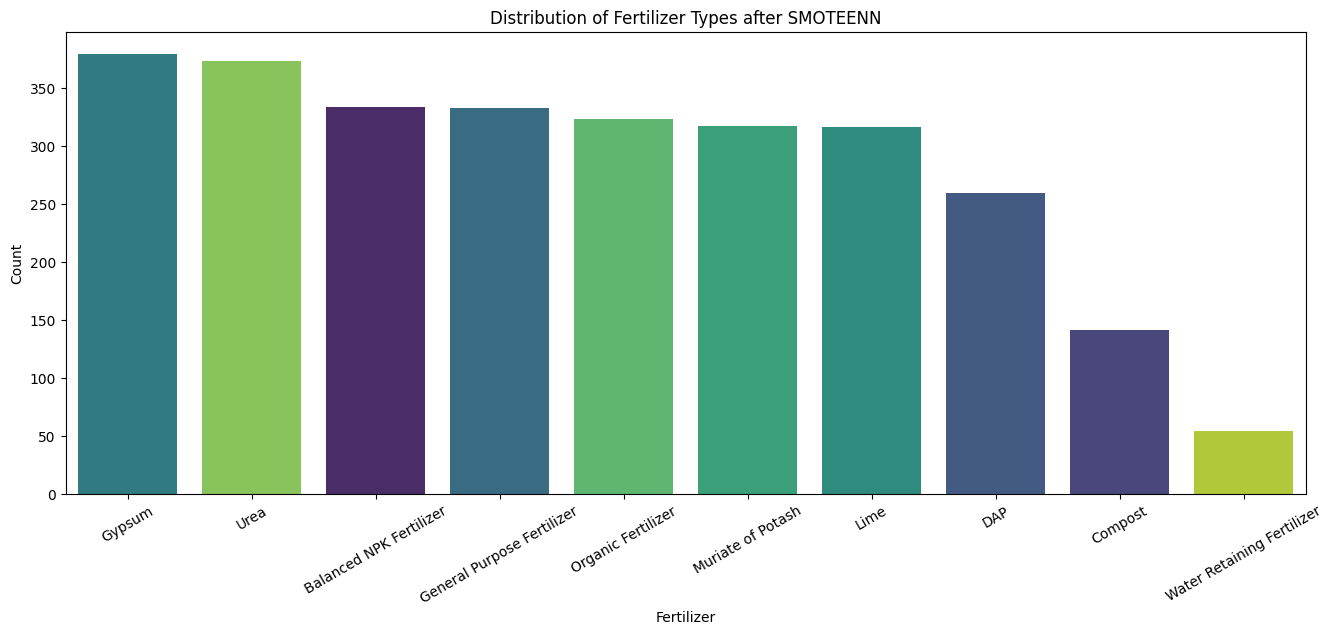

In [184]:
# Visualize fertilizer distribution after SMOTE
plt.figure(figsize=(16,6))
sns.countplot(x=y_resampled, order=y_resampled.value_counts().index, palette='viridis', hue=y_resampled)
plt.xticks(rotation=30)
plt.title('Distribution of Fertilizer Types after SMOTEENN')
plt.xlabel('Fertilizer')
plt.ylabel('Count')
plt.show()

In [185]:
# label encoder for fertilizer column
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
print('Enocded fertlizer types:\n')
for i, fertilizer in enumerate(le.classes_):
    print(f'{i}: {fertilizer}')

Enocded fertlizer types:

0: Balanced NPK Fertilizer
1: Compost
2: DAP
3: General Purpose Fertilizer
4: Gypsum
5: Lime
6: Muriate of Potash
7: Organic Fertilizer
8: Urea
9: Water Retaining Fertilizer


In [186]:
x_resampled.columns

Index(['Temperature', 'Moisture', 'Rainfall', 'PH', 'Nitrogen', 'Phosphorous',
       'Potassium', 'Carbon', 'Soil_Acidic Soil', 'Soil_Alkaline Soil',
       'Soil_Loamy Soil', 'Soil_Neutral Soil', 'Soil_Peaty Soil',
       'Crop_Black gram', 'Crop_Chickpea', 'Crop_Coconut', 'Crop_Coffee',
       'Crop_Cotton', 'Crop_Jute', 'Crop_Kidney Beans', 'Crop_Lentil',
       'Crop_Moth Beans', 'Crop_Mung Bean', 'Crop_Pigeon Peas', 'Crop_apple',
       'Crop_banana', 'Crop_grapes', 'Crop_maize', 'Crop_mango',
       'Crop_muskmelon', 'Crop_orange', 'Crop_papaya', 'Crop_pomegranate',
       'Crop_rice', 'Crop_watermelon'],
      dtype='object')

## Model building and training

In [187]:
# split dataset for test and train
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_encoded, test_size=0.2, random_state=42)
print(f'Train set size: {x_train.shape}')
print(f'Test set size: {x_test.shape}')

Train set size: (2261, 35)
Test set size: (566, 35)


### 1. Random Forest

In [188]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(x_train, y_train)
rf_y_predict = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_y_predict)
print(f'Random Forest Accuracy: {rf_accuracy}')
print(f'Detailed Classification Report: ')
print(classification_report(y_test, rf_y_predict, target_names=le.classes_))

Random Forest Accuracy: 0.9982332155477032
Detailed Classification Report: 
                            precision    recall  f1-score   support

   Balanced NPK Fertilizer       1.00      1.00      1.00        69
                   Compost       1.00      1.00      1.00        32
                       DAP       1.00      1.00      1.00        50
General Purpose Fertilizer       1.00      1.00      1.00        62
                    Gypsum       1.00      1.00      1.00        81
                      Lime       0.98      1.00      0.99        65
         Muriate of Potash       1.00      1.00      1.00        52
        Organic Fertilizer       1.00      1.00      1.00        71
                      Urea       1.00      1.00      1.00        74
Water Retaining Fertilizer       1.00      0.90      0.95        10

                  accuracy                           1.00       566
                 macro avg       1.00      0.99      0.99       566
              weighted avg       1.00 

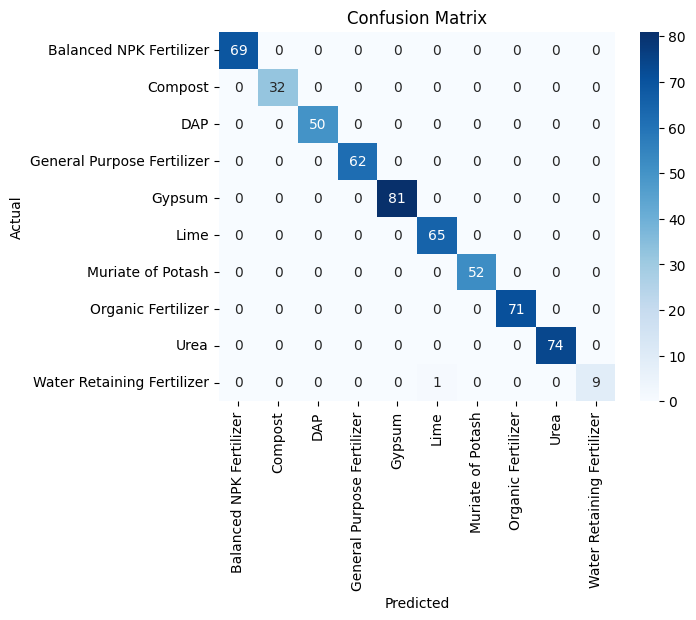

In [189]:
# confusion matrix

cm = confusion_matrix(y_test, rf_y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2. Decision Tree

In [190]:
dt_model = DecisionTreeClassifier(class_weight='balanced')
dt_model.fit(x_train, y_train)
dt_y_predict = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_y_predict)
print(f'Decision Tree Accuracy: {dt_accuracy}')
print(f'Detailed Classification Report: ')
print(classification_report(y_test, dt_y_predict, target_names=le.classes_))

Decision Tree Accuracy: 1.0
Detailed Classification Report: 
                            precision    recall  f1-score   support

   Balanced NPK Fertilizer       1.00      1.00      1.00        69
                   Compost       1.00      1.00      1.00        32
                       DAP       1.00      1.00      1.00        50
General Purpose Fertilizer       1.00      1.00      1.00        62
                    Gypsum       1.00      1.00      1.00        81
                      Lime       1.00      1.00      1.00        65
         Muriate of Potash       1.00      1.00      1.00        52
        Organic Fertilizer       1.00      1.00      1.00        71
                      Urea       1.00      1.00      1.00        74
Water Retaining Fertilizer       1.00      1.00      1.00        10

                  accuracy                           1.00       566
                 macro avg       1.00      1.00      1.00       566
              weighted avg       1.00      1.00      

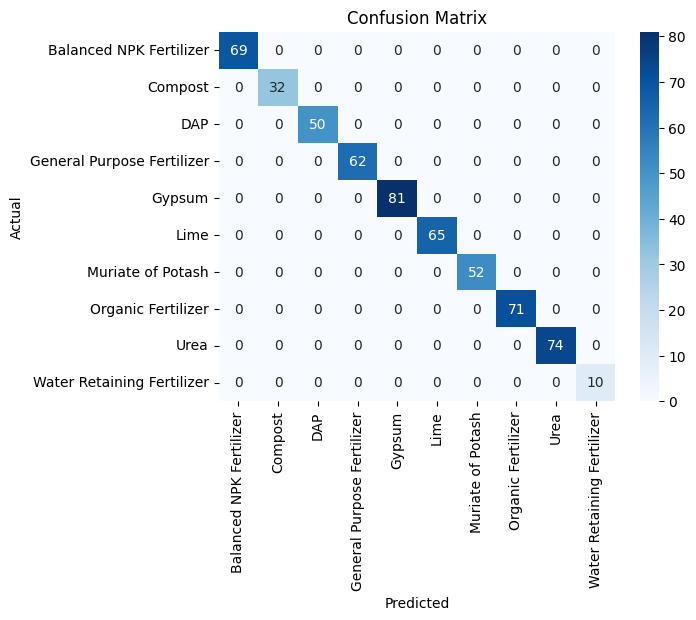

In [191]:
cm = confusion_matrix(y_test, dt_y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 3. Gradient Boosting

In [192]:
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)
gb_y_predict = gb_model.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_y_predict)
print(f'Gradient Boosting Accuracy: {gb_accuracy}')
print(f'Detailed Classification Report: ')
print(classification_report(y_test, gb_y_predict, target_names=le.classes_))

Gradient Boosting Accuracy: 0.9982332155477032
Detailed Classification Report: 
                            precision    recall  f1-score   support

   Balanced NPK Fertilizer       1.00      1.00      1.00        69
                   Compost       1.00      1.00      1.00        32
                       DAP       1.00      1.00      1.00        50
General Purpose Fertilizer       1.00      1.00      1.00        62
                    Gypsum       1.00      1.00      1.00        81
                      Lime       1.00      0.98      0.99        65
         Muriate of Potash       1.00      1.00      1.00        52
        Organic Fertilizer       0.99      1.00      0.99        71
                      Urea       1.00      1.00      1.00        74
Water Retaining Fertilizer       1.00      1.00      1.00        10

                  accuracy                           1.00       566
                 macro avg       1.00      1.00      1.00       566
              weighted avg       1

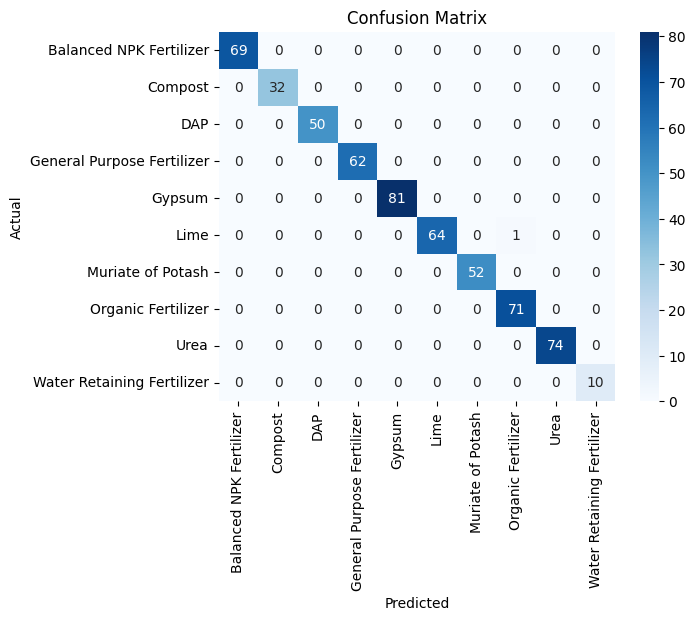

In [193]:
cm = confusion_matrix(y_test, gb_y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [194]:
# Compare models based on multiple metrics
models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'Gradient Boosting': gb_model
}

predictions = {
    'Random Forest': rf_y_predict,
    'Decision Tree': dt_y_predict,
    'Gradient Boosting': gb_y_predict
}

metrics = {}

print("\n--- Model Comparison ---")
for name, model in models.items():
    y_pred = predictions[name]
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    metrics[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }
    
    print(f"\n{name} Model:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - F1 Score: {f1:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")

# Find the best model based on F1 score (more balanced metric than accuracy)
best_model_name = max(metrics, key=lambda x: metrics[x]['f1_score'])
best_model = models[best_model_name]
best_score = metrics[best_model_name]['f1_score']

print(f"\n✅ Best Model: {best_model_name} (F1 Score: {best_score:.4f})")



--- Model Comparison ---

Random Forest Model:
  - Accuracy: 0.9982
  - F1 Score: 0.9982
  - Precision: 0.9983
  - Recall: 0.9982

Decision Tree Model:
  - Accuracy: 1.0000
  - F1 Score: 1.0000
  - Precision: 1.0000
  - Recall: 1.0000

Gradient Boosting Model:
  - Accuracy: 0.9982
  - F1 Score: 0.9982
  - Precision: 0.9983
  - Recall: 0.9982

✅ Best Model: Decision Tree (F1 Score: 1.0000)


### Exporting the model

In [195]:
# Create a directory to save models if it doesn't exist
os.makedirs('../models', exist_ok=True)

In [196]:
# Save the best model as a .pkl file
best_model_path = f'../models/fertilizer_recommender_{best_model_name.replace(" ", "_").lower()}.pkl'
pickle.dump(best_model, open(best_model_path, 'wb'))
print(f"Model saved to: {best_model_path}")

# Save label encoder for future prediction
le_path = '../models/label_encoder.pkl'
pickle.dump(le, open(le_path, 'wb'))
print(f"Label encoder saved to: {le_path}")

# Save feature columns order for future prediction (important for using the model later)
feature_names = x_resampled.columns.tolist()
features_path = '../models/feature_names.pkl'
pickle.dump(feature_names, open(features_path, 'wb'))
print(f"Feature names saved to: {features_path}")


Model saved to: ../models/fertilizer_recommender_decision_tree.pkl
Label encoder saved to: ../models/label_encoder.pkl
Feature names saved to: ../models/feature_names.pkl


In [197]:
feature_names

['Temperature',
 'Moisture',
 'Rainfall',
 'PH',
 'Nitrogen',
 'Phosphorous',
 'Potassium',
 'Carbon',
 'Soil_Acidic Soil',
 'Soil_Alkaline Soil',
 'Soil_Loamy Soil',
 'Soil_Neutral Soil',
 'Soil_Peaty Soil',
 'Crop_Black gram',
 'Crop_Chickpea',
 'Crop_Coconut',
 'Crop_Coffee',
 'Crop_Cotton',
 'Crop_Jute',
 'Crop_Kidney Beans',
 'Crop_Lentil',
 'Crop_Moth Beans',
 'Crop_Mung Bean',
 'Crop_Pigeon Peas',
 'Crop_apple',
 'Crop_banana',
 'Crop_grapes',
 'Crop_maize',
 'Crop_mango',
 'Crop_muskmelon',
 'Crop_orange',
 'Crop_papaya',
 'Crop_pomegranate',
 'Crop_rice',
 'Crop_watermelon']

## Testing Model

In [198]:
# Quick demonstration of how to use the saved model for prediction
def predict_fertilizer(input_data, model_path, le_path, features_path):
    """
    Example function to show how to use the saved model for prediction
    
    Parameters:
    - input_data: DataFrame containing soil properties and crop information
    - model_path: Path to the saved model
    - le_path: Path to the saved label encoder
    - features_path: Path to the saved feature names
    
    Returns:
    - Predicted fertilizer name
    """
    # Load model, label encoder and feature names
    model = pickle.load(open(model_path, 'rb'))
    loaded_le = pickle.load(open(le_path, 'rb'))
    feature_names = pickle.load(open(features_path, 'rb'))
    
    # Ensure input data has the same features in the same order
    if not all(feature in input_data.columns for feature in feature_names):
        missing = [f for f in feature_names if f not in input_data.columns]
        raise ValueError(f"Input data missing required features: {missing}")
    
    # Reorder columns to match training data
    input_data = input_data[feature_names]
    
    # Make prediction
    pred_encoded = model.predict(input_data)
    prediction = loaded_le.inverse_transform(pred_encoded)
    
    return prediction


In [199]:
# Example code to use the saved model with the new column structure
import pickle
import pandas as pd
import numpy as np

# Load model components
best_model_path = '../models/fertilizer_recommender_{}.pkl'.format(best_model_name.replace(" ", "_").lower())
model = pickle.load(open(best_model_path, 'rb'))
le = pickle.load(open('../models/label_encoder.pkl', 'rb'))
feature_names = pickle.load(open('../models/feature_names.pkl', 'rb'))

# Create a function to prepare input data with the new column structure
def prepare_input_data(temperature, moisture, rainfall, ph, nitrogen, phosphorous, potassium, carbon, soil_type, crop_type):
    """
    Create a DataFrame with all required columns and proper one-hot encoding
    
    Parameters:
    - temperature: float (e.g. 25.0)
    - moisture: float (e.g. 40.0)
    - rainfall: float (e.g. 120.0)
    - ph: float (e.g. 6.5)
    - nitrogen: int (e.g. 80)
    - phosphorous: int (e.g. 45)
    - potassium: int (e.g. 40)
    - carbon: float (e.g. 1.2)
    - soil_type: string (e.g. 'Loamy Soil')
    - crop_type: string (e.g. 'Cotton')
    
    Returns:
    - DataFrame with all required columns
    """
    # Create a DataFrame with numeric values
    input_data = pd.DataFrame({
        'Temperature': [temperature],
        'Moisture': [moisture],
        'Rainfall': [rainfall],
        'PH': [ph],
        'Nitrogen': [nitrogen],
        'Phosphorous': [phosphorous],
        'Potassium': [potassium],
        'Carbon': [carbon]
    })
    
    # Get all possible soil types from the feature names
    soil_columns = [col for col in feature_names if col.startswith('Soil_')]
    for col in soil_columns:
        soil_name = col.replace('Soil_', '')
        input_data[col] = 1 if soil_name == soil_type else 0
    
    # Get all possible crop types from the feature names
    crop_columns = [col for col in feature_names if col.startswith('Crop_')]
    for col in crop_columns:
        crop_name = col.replace('Crop_', '')
        input_data[col] = 1 if crop_name == crop_type else 0
    
    # Ensure all columns from feature_names are in the DataFrame
    missing_cols = set(feature_names) - set(input_data.columns)
    for col in missing_cols:
        input_data[col] = 0
    
    # Reorder columns to match training data
    input_data = input_data[feature_names]
    
    return input_data

# Example usage
input_data = prepare_input_data(
    temperature=25.0,
    moisture=40.0,
    rainfall=120.0,
    ph=6.5,
    nitrogen=80,
    phosphorous=45,
    potassium=40,
    carbon=1.2,
    soil_type='Loamy Soil',
    crop_type='Cotton'
)

# Make prediction
prediction_encoded = model.predict(input_data)
fertilizer_prediction = le.inverse_transform(prediction_encoded)

print(f"Recommended fertilizer: {fertilizer_prediction[0]}")

Recommended fertilizer: DAP
